In [405]:
from __future__ import division, unicode_literals

import pandas as pd
import numpy as np
import math

from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split, StratifiedKFold
from pandas.tools.plotting import scatter_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl
from IPython.display import Image

# Чтение данных

In [487]:
train = pd.read_csv('train.csv', encoding='utf-8', 
                    dialect='excel', lineterminator='\n')

assert(train.columns[-1] == 'retweet_count')

train_f = train[['user.statuses_count', 'user.followers_count', 
                'user.friends_count', 'user.listed_count', 'user.favourites_count']]

# Пре-процессинг данных

Размеры данный

In [488]:
print train_f.shape

(67211, 5)


In [489]:
train_f.head()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
0,1606,9164,205,27,758
1,3004,7484,708,330,44
2,3988,2050,491,70,422
3,9018,919,309,38,79
4,32527,85356,912,1232,137


Характеристики данных

In [490]:
train_f.describe()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
count,6.721100e+04,6.721100e+04,6.721100e+04,67211.000000,67211.000000
mean,9.214209e+04,2.493563e+05,6.381893e+03,1829.584012,3488.091994
std,1.990518e+05,1.101774e+06,3.638143e+04,8257.238243,12399.361134
min,6.000000e+00,3.500000e+01,0.000000e+00,0.000000,0.000000
25%,9.716500e+03,8.762000e+03,4.030000e+02,138.000000,111.000000
50%,2.799800e+04,4.064900e+04,9.290000e+02,471.000000,722.000000
75%,7.583100e+04,1.462430e+05,2.659000e+03,1332.000000,2481.000000
max,1.775275e+06,6.622713e+07,3.131983e+06,584387.000000,623798.000000


Построим корреляционную матрицу для оценивания наличия линейной зависимости между признаками. Можно заметить, что признауи не скореллированы, только 'user.listed_count' и 'user.followers_count' имеют коэффициетн = 0.846. Это следует учитывать при построении линейных классификаторов.

In [491]:
train_f.corr()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
user.statuses_count,1.000000,0.052894,0.127003,0.054768,0.024958
user.followers_count,0.052894,1.000000,0.136822,0.845898,0.022280
user.friends_count,0.127003,0.136822,1.000000,0.099393,0.179443
user.listed_count,0.054768,0.845898,0.099393,1.000000,0.020612
user.favourites_count,0.024958,0.022280,0.179443,0.020612,1.000000


Визуализация данных.
Диапазон значений параметров довольно сильно отличается. Пэтому их необходимо преобразовать. Добавим +1 к каждому параметру и прологорифмируем эти значения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124035ed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110854c90>]], dtype=object)

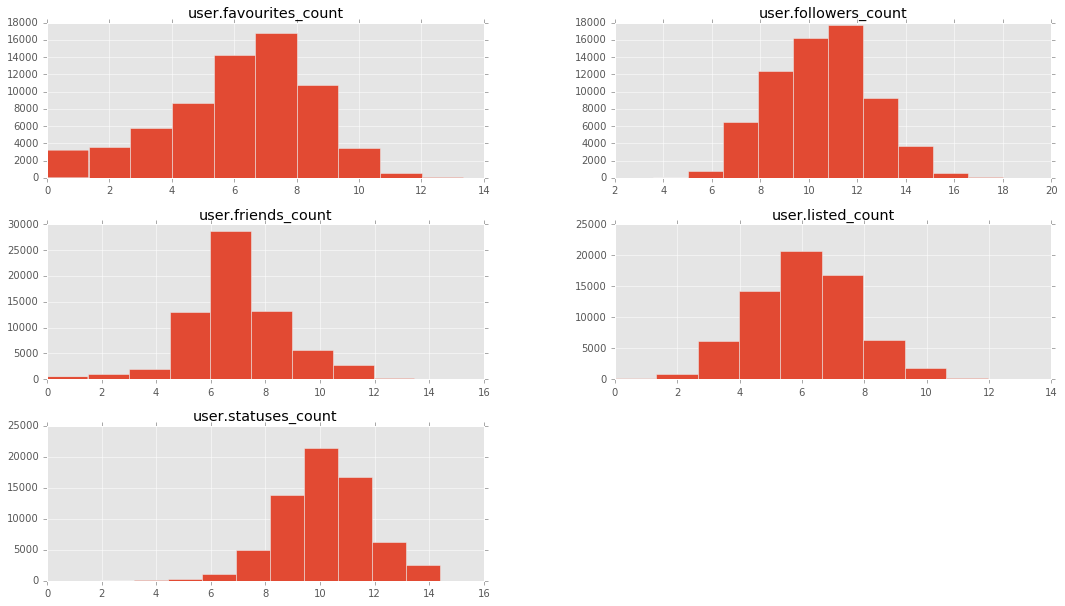

In [492]:
plt.style.use('ggplot')
# init data
# pd.DataFrame.hist(train_f, figsize = [18,10])
train_log = train_f.applymap(lambda x : x + 1).applymap(math.log)
# data ufter log operation
pd.DataFrame.hist(train_log, figsize = [18,10])

# train_log.corr()

# Пример вычисления признаков

In [493]:
def df2features(df):
    return np.array([
        df['user.statuses_count'],
        df['user.followers_count'],
        df['user.friends_count'],
        df['user.listed_count'],
        df['user.favourites_count'],
    ]).transpose()

train_x = df2features(train_log)
train_y = train['retweet_count'] > 20

# Построение модели

Пример вычисления площади под ROC-кривой на обучающей выборке.

In [494]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, svm

from sklearn.metrics import roc_curve, auc

In [495]:
model_dtc = DecisionTreeClassifier()
model_lr = LogisticRegression(penalty='l1', tol=0.01)
model_rfc = RandomForestClassifier(n_estimators = 10)

## KNN

Поиск оптимального значения K для KNN

In [496]:
model_knc = KNeighborsClassifier(n_neighbors = 10)

Определение оптимального параметра k при разном разбиении для CV

In [502]:
# define the parameter values that should be searched
k_range = range(29, 47, 2)
cv_range = range(45, 120, 5)
param_grid = dict(n_neighbors=k_range)
best_score_list = []
best_params_list = []
for cv in cv_range:
    grid = GridSearchCV(model_knc, param_grid, cv=cv, scoring='roc_auc')
    grid.fit(train_x, train_y)
    scores_list = [round(result.mean_validation_score, 3) for result in grid.grid_scores_]
    params_list = [result.parameters['n_neighbors'] for result in grid.grid_scores_]
    best_score = max(scores_list)
    best_score_list.append(best_score)
    best_params_list.append(params_list[scores_list.index(best_score)])

In [ ]:
plt.plot(cv_range, best_score_list)
plt.xlabel('CV param')
plt.ylabel('Best AUC Score')
plt.title('Tune Folds param')

3  ПАРАМЕТРА.
Анплизируя график, тестовую выборку можно поделить на сv = 55 частей(k optimum = 25). Этит мы выиграем в производительности, в сравнении с cv = 55 и практически не теряя точности. 3 параметра: 'user.followers_count', 'user.friends_count'. 'user.listed_count'. Log data

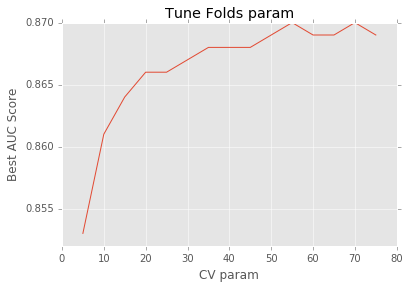

In [512]:
Image(filename='img/knn_3par_log.png')

5  ПАРАМЕТРОВ.
Анплизируя график, тестовую выборку можно поделить на сv = 75 частей(k optimum = 41). Log data

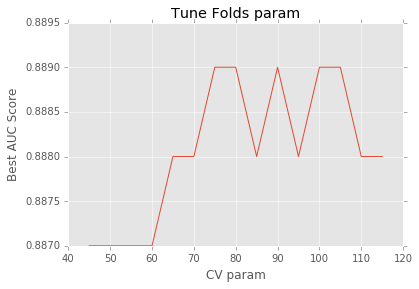

In [511]:
Image(filename='img/knn_5par_log.png')

Прогноз с подобранными параметрами. В качестве получения тренировочных и проверочных выборок будем использовать StratifiedKFold, GridSearchCV также её испльзует

In [509]:
folds = 75
model_knc = KNeighborsClassifier(n_neighbors = 41)
skf = StratifiedKFold(train_y, n_folds=folds)
auc_list = []

for train_index, test_index in skf:
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    model_knc.fit(X_train, y_train)
    proba = model_knc.predict_proba(X_test)
    auc = roc_auc_score(y_test, proba[:,1])
    auc_list.append(auc)


In [ ]:
print 'AUC mean: {}, AUC std: {}'.format(np.mean(auc_list), np.std(auc_list))

Лучише результаты с 3 параметрами Log data:
AUC mean: 0.868066856968, AUC std: 0.0241453152241

Лучише результаты с 5 параметрами Log data:
AUC mean: 0.888662237754, AUC std: 0.022965750637

## LogisticRegression

In [ ]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
rfe = RFE(model_lr, 3)
rfe = rfe.fit(train_x, train_y)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

Кросс-валидация

In [ ]:
train_x_ROC, test_x_ROC, train_y_ROC, test_y_ROC = cross_validation.train_test_split(train_x, train_y, test_size=0.2)

In [ ]:
kfold = 5 #количество подвыборок для валидации
acc_val = {}
scores = cross_validation.cross_val_score(model_dtc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['DecisionTreeClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_lr, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['LogisticRegression'] = scores.mean()
scores = cross_validation.cross_val_score(model_rfc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['RandomForestClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['KNeighborsClassifier'] = scores.mean()


In [ ]:
plt.bar(range(len(acc_val)), acc_val.values(), align='center')
plt.xticks(range(len(acc_val)), acc_val.keys(), rotation='vertical')
pl.ylabel('Accuracy')
plt.show()

Визуализация ROC-кривой

In [ ]:
pl.clf()
plt.figure(figsize=(8,6))
#DecisionTreeClassifier
probas = model_dtc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('DecisionTreeClassifier',roc_auc))
#LogisticRegression
probas = model_lr.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
#RandomForestClassifier
probas = model_rfc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForestClassifier',roc_auc))
#KNeighborsClassifier
probas = model_knc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))

pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

# Построение и запись финального прогноза

Строим новый прогноз и обновляем вероятности того, что ретвитов больше 20.

In [ ]:
proba = est.predict_proba(test_X)
prediction['probability'] = proba[:,1]

Записываем полученный результат в файл prediction.csv.

In [ ]:
# prediction.to_csv('prediction.csv', index=False)